# Holiday shipping cut-off forecasting 

In [1]:
import pandas as pd
import numpy
import sklearn
import scipy
import matplotlib 
import statsmodels


/Users/aikumar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### Import data 

In [2]:
data = pd.read_csv("/Users/aikumar/Documents/Projects/Holiday shipping cut-off/data.csv", parse_dates=['Date'], names=['Date', 'txns', 'sales'], skiprows =1)
data.head()

,Date,txns,sales
0,2016-01-01,83654.0,6017269.12
1,2016-01-02,84153.0,6242445.90
2,2016-01-03,96520.0,7239796.48
3,2016-01-04,79451.0,5311635.66
4,2016-01-05,79095.0,5372856.17


In [3]:
data.dtypes

Date     datetime64[ns]
txns            float64
sales           float64
dtype: object

In [ ]:
# data['shpg_trxn_ln_dt'] = data['shpg_trxn_ln_dt'].apply(pd.to_datetime)

### EDA 

In [4]:
print(data.describe())

                txns         sales
count    1826.000000  1.826000e+03
mean    71880.868565  5.525029e+06
std     45039.004303  3.813533e+06
min        55.000000  9.335700e+02
25%     46714.500000  3.561725e+06
50%     58830.500000  4.468120e+06
75%     80868.250000  6.132310e+06
max    530026.000000  4.594013e+07


#### Visualizing the data 

(array([16436., 16801., 17167., 17532., 17897., 18262., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

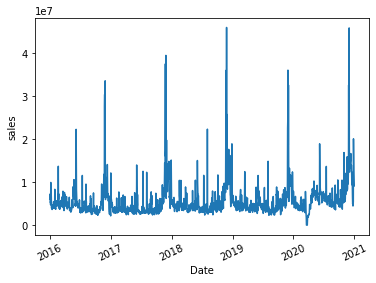

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
# create the time series plot
sns.lineplot(x = "Date", y = "sales",
             data = data)
  
plt.xticks(rotation = 25)

In [8]:
data_3yrs =  data[data["Date"] >= '2018-01-01']

In [9]:
data_3yrs

,Date,txns,sales
731,2018-01-01,64383.0,4994680.80
732,2018-01-02,66862.0,4841329.65
733,2018-01-03,77793.0,5738305.45
734,2018-01-04,81369.0,5886011.52
735,2018-01-05,67800.0,4929070.47
...,...,...,...
1821,2020-12-26,226742.0,20056461.24
1822,2020-12-27,181820.0,16053121.64
1823,2020-12-28,141793.0,12128303.92
1824,2020-12-29,131144.0,10984331.93


(array([17532., 17652., 17775., 17897., 18017., 18140., 18262., 18383.,
        18506., 18628.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

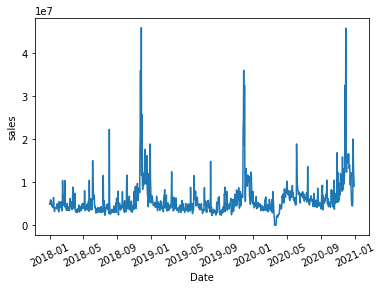

In [10]:
# create the time series plot
sns.lineplot(x = "Date", y = "sales",
             data = data_3yrs)
  
plt.xticks(rotation = 25)

#### Density plot 

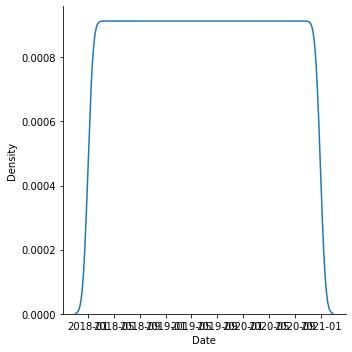

In [11]:
sns.displot(data_3yrs, x="Date", kind="kde",  bw_adjust=0.25)

In [ ]:
#### Boxplot

In [12]:
data_3yrs_yr = pd.DataFrame(data_3yrs.copy())
data_3yrs_yr['yr']= data_3yrs_yr['Date'].dt.year

In [13]:
data_3yrs_yr.head()

,Date,txns,sales,yr
731,2018-01-01,64383.0,4994680.80,2018
732,2018-01-02,66862.0,4841329.65,2018
733,2018-01-03,77793.0,5738305.45,2018
734,2018-01-04,81369.0,5886011.52,2018
735,2018-01-05,67800.0,4929070.47,2018


<AxesSubplot:xlabel='yr', ylabel='sales'>

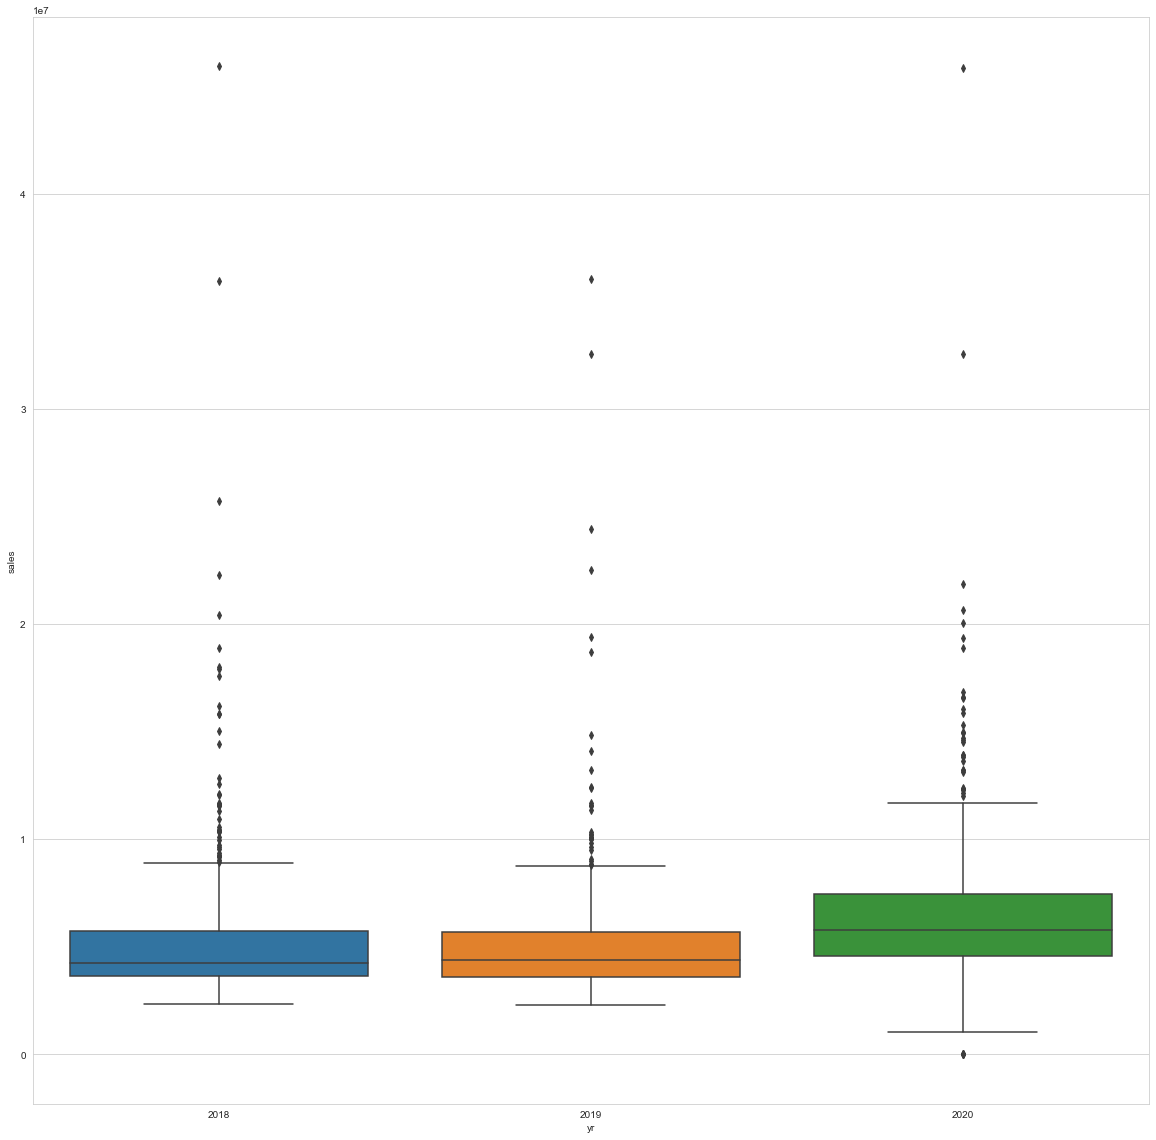

In [17]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
  
sns.boxplot(x = 'yr', y = 'sales', data = data_3yrs_yr)

In [ ]:
##############

### Checking for stationarity

In [18]:
ts = data_3yrs_yr[['Date','sales']]
ts.head()

,Date,sales
731,2018-01-01,4994680.80
732,2018-01-02,4841329.65
733,2018-01-03,5738305.45
734,2018-01-04,5886011.52
735,2018-01-05,4929070.47


In [19]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['sales'])

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.417247
p-value: 0.000277
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


Since the test statistic is lesser than the critical value at 1% significance level, we can reject the null hypothesis with 99% confidence interval.

This means that the time series is stationary

In [ ]:
# # create a differenced series
# def difference(dataset, interval=1):
#     diff = list()
#     for i in range(interval, len(dataset)):
#         value = dataset[i] - dataset[i - interval]
#         diff.append(value)    
#     return pd.Series(diff)

In [ ]:
### Finding p and q 

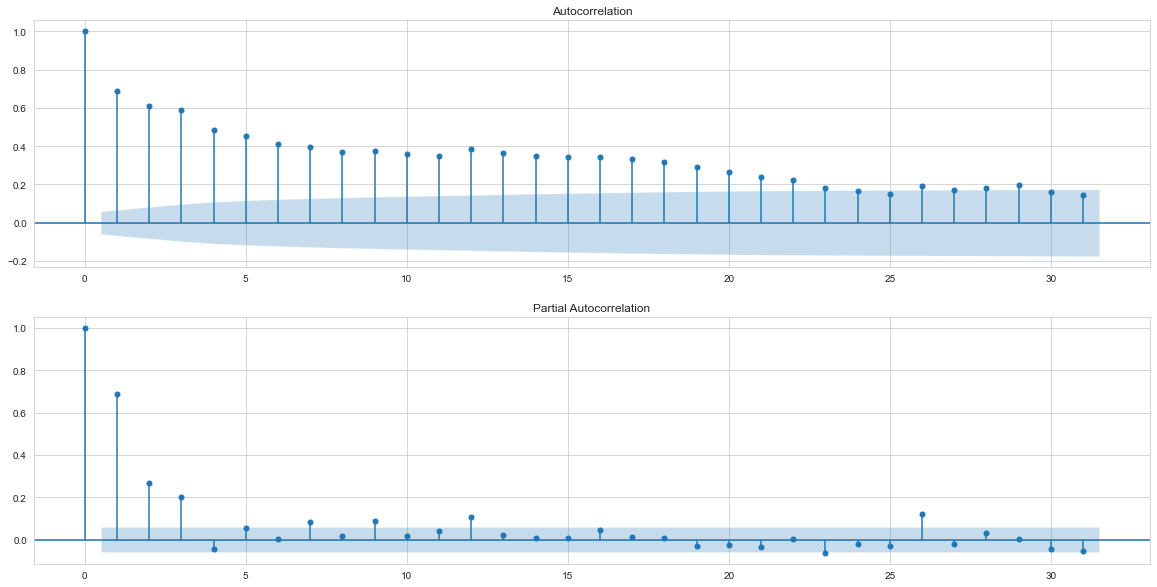

In [24]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot


pyplot.figure(figsize=(20,10))
pyplot.subplot(211)
plot_acf(ts['sales'], ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(ts['sales'], ax=pyplot.gca())
pyplot.show()

#### Build the model 

In [25]:
# split dataset between training and testing
cutoff_30pct = len(ts['sales'])-int(len(ts['sales'])*0.3)
y_train = ts['sales'][:cutoff_30pct]
y_test = ts['sales'][cutoff_30pct:] 

In [26]:
# building the model with the parameters we've discovered and fitting it to the training set
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(y_train, order=(1,0,1)) 
arima_model_fit = model.fit(disp=-1)
print(arima_model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  sales   No. Observations:                  767
Model:                     ARMA(1, 1)   Log Likelihood              -12437.061
Method:                       css-mle   S.D. of innovations        2665099.139
Date:                Thu, 01 Apr 2021   AIC                          24882.123
Time:                        13:36:42   BIC                          24900.693
Sample:                             0   HQIC                         24889.271
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         5.41e+06    4.9e+05     11.041      0.000    4.45e+06    6.37e+06
ar.L1.sales     0.8965      0.021     42.162      0.000       0.855       0.938
ma.L1.sales    -0.4678      0.042    -11.070    

/Users/aikumar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/aikumar/.pyenv/versions/3.7.3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index w

In [ ]:
#############

In [27]:
# grid search ARIMA parameters for time series
import warnings
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy


In [28]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)    
    return pd.Series(diff)

In [29]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [30]:
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        days_in_year = 365
        diff = difference(history, days_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()
        yhat = inverse_difference(history, yhat, days_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [31]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))


In [32]:
# evaluate parameters
p_values = range(0, 2)
d_values = range(0, 0)
q_values = range(0, 2)
warnings.filterwarnings("ignore")
evaluate_models(ts['sales'].values, p_values, d_values, q_values)

Best ARIMANone RMSE=inf


In [ ]:
#################

In [33]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings
warnings.filterwarnings('ignore')

from pmdarima.arima import auto_arima

In [34]:
#Read the sales dataset
sales_data = ts
sales_data.head()

,Date,sales
731,2018-01-01,4994680.80
732,2018-01-02,4841329.65
733,2018-01-03,5738305.45
734,2018-01-04,5886011.52
735,2018-01-05,4929070.47


In [35]:
#Set the index as the date 
sales_data.set_index('Date',inplace=True)
sales_data.head()

,sales
Date,
2018-01-01,4994680.80
2018-01-02,4841329.65
2018-01-03,5738305.45
2018-01-04,5886011.52
2018-01-05,4929070.47


<AxesSubplot:xlabel='Date'>

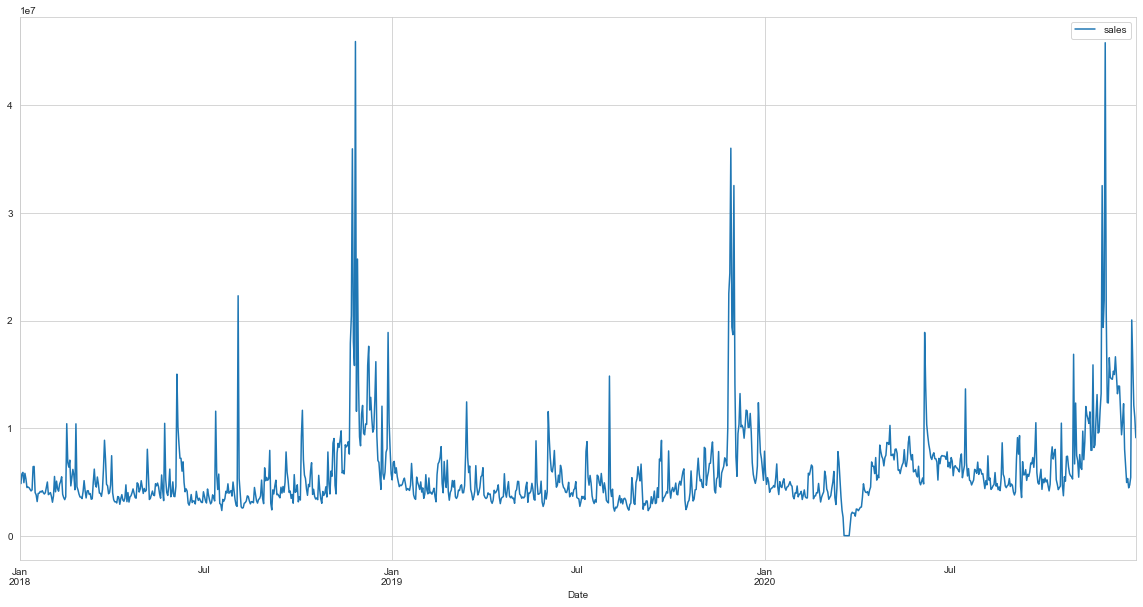

In [37]:
# To understand the pattern
sales_data.plot(figsize=(20,10))


In [38]:
sales_data

,sales
Date,
2018-01-01,4994680.80
2018-01-02,4841329.65
2018-01-03,5738305.45
2018-01-04,5886011.52
2018-01-05,4929070.47
...,...
2020-12-26,20056461.24
2020-12-27,16053121.64
2020-12-28,12128303.92


In [ ]:
# #Testing for stationarity
# from pmdarima.arima import ADFTest
# adf_test = ADFTest(alpha = 0.05)
# adf_test.should_diff(sales_data)

In [39]:
len(sales_data)

1095

In [40]:
#Spliting the dataset into train and test
cutoff_30pct = len(sales_data)-int(len(sales_data)*0.3)

train = sales_data[:cutoff_30pct]
test = sales_data[cutoff_30pct:]

print(train.tail())
print(test.head())


                 sales
Date                  
2020-02-02  4622689.38
2020-02-03  3611110.13
2020-02-04  3852402.55
2020-02-05  3893833.38
2020-02-06  4124388.00
                 sales
Date                  
2020-02-07  3361988.65
2020-02-08  3775662.39
2020-02-09  4256869.23
2020-02-10  3621605.29
2020-02-11  3507566.30


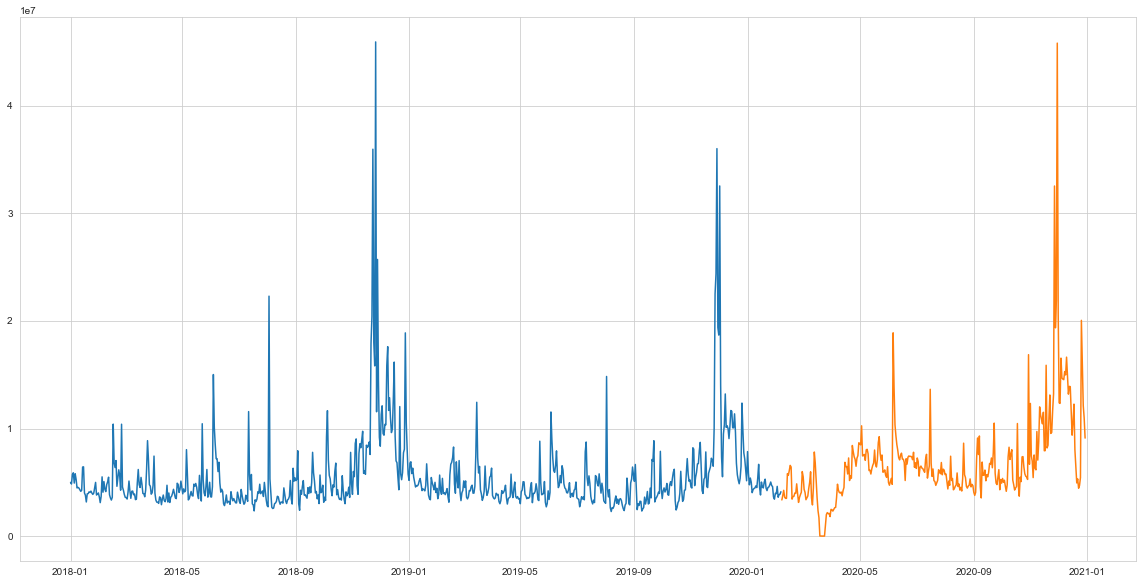

In [44]:
plt.figure(figsize=(20,10))
plt.plot(train)
plt.plot(test)

In [45]:

arima_model =  auto_arima(train,start_p=0, d=0, start_q=0, 
                          max_p=5, max_d=5, max_q=5,  m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )


#Summary of the model
arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=25329.071, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=25388.682, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=24955.220, Time=0.31 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=25150.683, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=26258.273, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=24962.499, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=24955.657, Time=1.38 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=24957.177, Time=0.52 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=24956.227, Time=0.16 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=24956.514, Time=1.31 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=25366.829, Time=0.13 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=24894.905, Time=0.48 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=24898.890, Time=0.06 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=24896.676, Time=2.60 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  767
Model:             SARIMAX(5, 0, 0)x(1, 0, 0, 12)   Log Likelihood              -12428.592
Date:                            Thu, 01 Apr 2021   AIC                          24873.184
Time:                                    13:39:03   BIC                          24910.323
Sample:                                         0   HQIC                         24887.479
                                            - 767                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.071e+06   1.86e-09   5.75e+14      0.000    1.07e+06    1.07e+06
ar.L1          0.4255      0.016     27.404      0.000       0.395       0.456
ar.L2          0.2019      0.020     10.087      0.000       0.163       0.241
ar.L3          0.1789      0.013     14.241      0.000       0.154       0.204
ar.L4         -0.0836      0.026     -3.234      0.001      -0.134      -0.033
ar.L5          0.0627      0.024      2.581      0.010       0.015       0.110
ar.S.L12       0.0753      0.030      2.470      0.014       0.016       0.135
sigma2      7.029e+12   3.15e-15   2.23e+27      0.000    7.03e+12    7.03e+12
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             38120.13
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.75   Skew:                             3.97
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.1e+42. Standard errors may be unstable.
"""

In [ ]:
start_P=0,D=0, start_Q=0, max_P=5, max_D=5,max_Q=5,

In [46]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 328),index=test.index)
prediction.columns = ['predicted_sales']
prediction

,predicted_sales
Date,
2020-02-07,4.390011e+06
2020-02-08,4.440163e+06
2020-02-09,4.562270e+06
2020-02-10,4.589247e+06
2020-02-11,4.647846e+06
...,...
2020-12-26,5.395190e+06
2020-12-27,5.395190e+06
2020-12-28,5.395190e+06


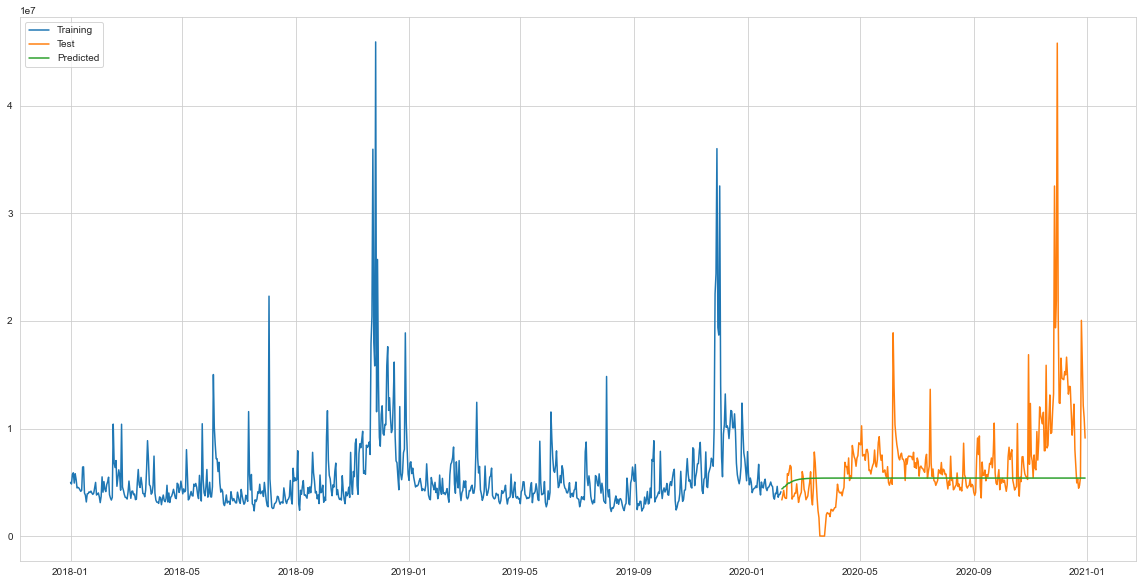

In [47]:
plt.figure(figsize=(20,10))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.legend(loc = 'best')
plt.show()

In [48]:
from sklearn.metrics import r2_score
test['predicted_sales'] = prediction
r2_score(test['sales'], test['predicted_sales'])


-0.12039494921345151